In [1]:
### REMOVE LATER ###
# Go up one directory since notebook inside task3/ folder.
import os

try:
    if UP_DIR:
        print("skipping")
except NameError:
    os.chdir("..")
    UP_DIR = True

# JH's Task 3 Experiment 2
(NOTE: keep this H1 header block or add it later to denote the boundaries between notebooks when we combined later)

Attempting Hyperparameter Sweep using Optuna.

## Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from copy import deepcopy
from task3.exp2 import Hparams, tfidf_to_np, train, inference

## Hyperparameters

In [3]:
TRAIN_CSV = "./data/train.csv"
TRAIN_TFIDF_CSV = "./data/train_tfidf_features.csv"
TEST_CSV = "./data/test.csv"
TEST_TFIDF_CSV = "./data/test_tfidf_features.csv"
HP = Hparams()

## Data Engineering
Instead of using the tfidf features given in the comp, we can engineer our own tfidf features with better filtering logic, or using something other than tfidf altogether to arrive at vector representations, or perhaps even use a strategy that use non-vector representations.

### Load Data

In [4]:
# train_df = pd.read_csv(TRAIN_CSV, index_col="id")
train_tfidf_df = pd.read_csv(TRAIN_TFIDF_CSV, index_col="id")
# test_df = pd.read_csv(TEST_CSV, index_col="id")
test_tfidf_df = pd.read_csv(TEST_TFIDF_CSV, index_col="id")

In [5]:
train_X, val_X, train_y, val_y = train_test_split(
    *tfidf_to_np(train_tfidf_df), test_size=HP.val_split, random_state=HP.seed
)
test_X, test_y = tfidf_to_np(test_tfidf_df)

print("Dataset splits:")
print("  train:", len(train_X))
print("  val:  ", len(val_X))
print("  test: ", len(test_X))

Dataset splits:
  train: 13747
  val:   3437
  test:  4296


## Optuna Hyperparameter Optimization
Setting up hyperparameter search using Optuna to find optimal parameters for our XGBoost + PCA pipeline.

In [6]:
def objective(trial):
    """Objective function for Optuna optimization."""

    # Create a copy of base hyperparameters
    hp = deepcopy(HP)
    hp.num_rounds = 1

    best = {
        "xgb_num_parallel_tree": 790,
        "pca_n_components": 500,
        "xgb_max_depth": 8,
        "xgb_learning_rate": 0.0500078001657761,
        "xgb_subsample": 0.8906661021635841,
        "xgb_colsample_bynode": 0.5969982674883092,
        "xgb_min_child_weight": 4.994051350455665,
        "xgb_min_split_loss": 0.6011102306375282,
        "xgb_lambda": 0.5148483961391062,
        "xgb_alpha": 1.5789563854205895,
    }

    hp.xgb_num_parallel_tree = trial.suggest_int(
        "xgb_num_parallel_tree", 200, 2000, step=50
    )
    hp.pca_n_components = trial.suggest_int("pca_n_components", 100, 1000, step=100)
    hp.xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 12)
    hp.xgb_learning_rate = trial.suggest_float(
        "xgb_learning_rate", 0.005, 0.2, log=True
    )
    hp.xgb_subsample = trial.suggest_float("xgb_subsample", 0.1, 1.0)
    hp.xgb_colsample_bynode = trial.suggest_float("xgb_colsample_bynode", 0.1, 0.95)
    hp.xgb_min_child_weight = trial.suggest_float("xgb_min_child_weight", 0.7, 10.0)
    hp.xgb_min_split_loss = trial.suggest_float("xgb_min_split_loss", 0.0, 1.0)
    hp.xgb_lambda = trial.suggest_float("xgb_lambda", 0.0, 5.0)
    hp.xgb_alpha = trial.suggest_float("xgb_alpha", 0.0, 5.0)

    try:
        # Train model with suggested hyperparameters
        results = train(
            hp, train_X=train_X, train_y=train_y, val_X=val_X, val_y=val_y, quiet=True
        )

        # Store results
        trial.set_user_attr("model_xgb", results["model_xgb"])
        trial.set_user_attr("model_pca", results["model_pca"])
        trial.set_user_attr("hyperparameters", hp)

        # Return val error
        return results["val_err"]

    except Exception as e:
        print(f"Trial failed with error: {e}")
        # Return high value for failed trials
        return 1.0

In [7]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
    direction="minimize",  # Minimize val error
    # Use TPE sampler for reproducibility
    sampler=optuna.samplers.TPESampler(seed=HP.seed),
)

study.optimize(objective, timeout=60 * 60 * 10, show_progress_bar=True)

print(f"Best validation error: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

   0%|          | 00:00/10:00:00

Best validation error: 0.2936
Best hyperparameters:
  xgb_num_parallel_tree: 2000
  pca_n_components: 400
  xgb_max_depth: 12
  xgb_learning_rate: 0.0277955545305884
  xgb_subsample: 0.9978357901381689
  xgb_colsample_bynode: 0.10943440889716287
  xgb_min_child_weight: 1.4829350577466396
  xgb_min_split_loss: 0.7055919743224333
  xgb_lambda: 0.5530974256648797
  xgb_alpha: 0.4060799698196474
  xgb_num_parallel_tree: 2000
  pca_n_components: 400
  xgb_max_depth: 12
  xgb_learning_rate: 0.0277955545305884
  xgb_subsample: 0.9978357901381689
  xgb_colsample_bynode: 0.10943440889716287
  xgb_min_child_weight: 1.4829350577466396
  xgb_min_split_loss: 0.7055919743224333
  xgb_lambda: 0.5530974256648797
  xgb_alpha: 0.4060799698196474


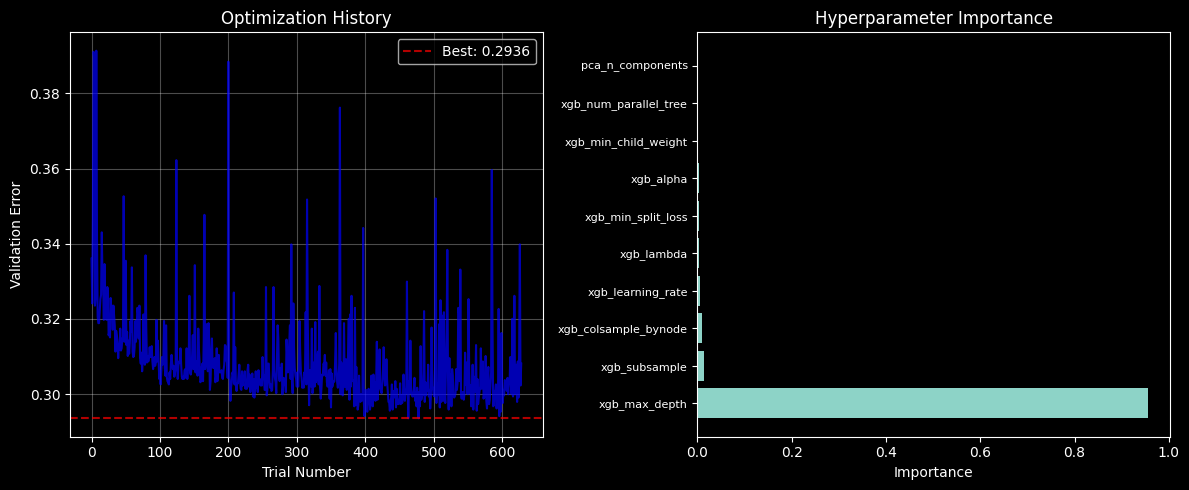

\nBest Trial Details:
Trial number: 463
Trial number: 463
Validation error: 0.2936
Parameters:
Validation error: 0.2936
Parameters:
  xgb_num_parallel_tree: 2000
  pca_n_components: 400
  xgb_max_depth: 12
  xgb_learning_rate: 0.0277955545305884
  xgb_subsample: 0.9978357901381689
  xgb_colsample_bynode: 0.10943440889716287
  xgb_min_child_weight: 1.4829350577466396
  xgb_min_split_loss: 0.7055919743224333
  xgb_lambda: 0.5530974256648797
  xgb_alpha: 0.4060799698196474
  xgb_num_parallel_tree: 2000
  pca_n_components: 400
  xgb_max_depth: 12
  xgb_learning_rate: 0.0277955545305884
  xgb_subsample: 0.9978357901381689
  xgb_colsample_bynode: 0.10943440889716287
  xgb_min_child_weight: 1.4829350577466396
  xgb_min_split_loss: 0.7055919743224333
  xgb_lambda: 0.5530974256648797
  xgb_alpha: 0.4060799698196474


In [8]:
# Analyze optimization results
import matplotlib.pyplot as plt

# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials if trial.value is not None]
trial_nums_valid = [trial.number for trial in study.trials if trial.value is not None]

ax1.plot(trial_nums_valid, trial_values, "b-", alpha=0.7)
ax1.axhline(
    y=min(trial_values),
    color="r",
    linestyle="--",
    alpha=0.7,
    label=f"Best: {min(trial_values):.4f}",
)
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Validation Error")
ax1.set_title("Optimization History")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter importance (if enough trials)
importance = optuna.importance.get_param_importances(study)
params = list(importance.keys())
values = list(importance.values())

ax2.barh(params, values)
ax2.set_xlabel("Importance")
ax2.set_title("Hyperparameter Importance")
ax2.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()

# Show best trial details
print("\\nBest Trial Details:")
print(f"Trial number: {study.best_trial.number}")
print(f"Validation error: {study.best_trial.value:.4f}")
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

In [9]:
best_trial = study.best_trial
best_results = {
    "model_xgb": best_trial.user_attrs["model_xgb"],
    "model_pca": best_trial.user_attrs["model_pca"],
    "val_err": best_trial.value,
}
best_hp = best_trial.user_attrs["hyperparameters"]

print(f"Best model validation error: {best_results['val_err']:.4f}")
print("Optimal hyperparameters:")
print(f"  PCA components: {best_hp.pca_n_components}")
print(f"  XGBoost max_depth: {best_hp.xgb_max_depth}")
print(f"  XGBoost learning_rate: {best_hp.xgb_learning_rate:.4f}")
print(f"  XGBoost subsample: {best_hp.xgb_subsample:.3f}")
print(f"  XGBoost colsample_bynode: {best_hp.xgb_colsample_bynode:.3f}")
print(f"  XGBoost min_child_weight: {best_hp.xgb_min_child_weight:.2f}")
print(f"  XGBoost min_split_loss: {best_hp.xgb_min_split_loss:.3f}")
print(f"  XGBoost lambda: {best_hp.xgb_lambda:.3f}")
print(f"  XGBoost alpha: {best_hp.xgb_alpha:.3f}")

Best model validation error: 0.2936
Optimal hyperparameters:
  PCA components: 400
  XGBoost max_depth: 12
  XGBoost learning_rate: 0.0278
  XGBoost subsample: 0.998
  XGBoost colsample_bynode: 0.109
  XGBoost min_child_weight: 1.48
  XGBoost min_split_loss: 0.706
  XGBoost lambda: 0.553
  XGBoost alpha: 0.406


## Inference with Optimized Model
Using the best hyperparameters found by Optuna optimization.

In [10]:
pred_y = inference(
    test_X, model_xgb=best_results["model_xgb"], model_pca=best_results["model_pca"]
)

In [11]:
from datetime import datetime

pred_df = pd.DataFrame(
    zip(test_tfidf_df.index, np.where(pred_y > 0.5, 1, 0)), columns=["row ID", "label"]
)
# YYYYMMDD-HHMM-optuna.csv
pred_df.to_csv(f"{datetime.now().strftime('%Y%m%d-%H%M')}-optuna.csv", index=False)